In [52]:
import pandas as pd;
pd.set_option('display.max_columns', None)

import statsmodels.api as sm

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns


In [53]:

data=pd.read_csv("CombinedCatsCleanedHotelBookings.csv")


In [54]:
def converting_datatypes(data):
    #Converting features to appropriate datatypes
    data["hotel"] = data["hotel"].astype("category")
    data["is_canceled"] = data["is_canceled"].astype("category")
    data["meal"] = data["meal"].astype("category")
    data["market_segment"] = data["market_segment"].astype("category")
    data["distribution_channel"] = data["distribution_channel"].astype("category")
    data["is_repeated_guest"] = data["is_repeated_guest"].astype("category")
    data["previous_cancellations"] = data["previous_cancellations"].astype(int)
    data["previous_bookings_not_canceled"] = data["previous_bookings_not_canceled"].astype(float)
    data["reserved_room_type"] = data["reserved_room_type"].astype("category")
    data["assigned_room_type"] = data["assigned_room_type"].astype("category")
    data["booking_changes"] = data["booking_changes"].astype(int)
    data["days_in_waiting_list"] = data["days_in_waiting_list"].astype(int)
    data["customer_type"] = data["customer_type"].astype("category")
    data["adr"] = data["adr"].astype(float)
    data["required_car_parking_spaces"] = data["required_car_parking_spaces"].astype(int)
    data["total_of_special_requests"] = data["total_of_special_requests"].astype(int)
    data["arrival_season"] = data["arrival_season"].astype("category")
    data['deposit_type']=data['deposit_type'].astype("category")
    data["arrival_weekday"] = data["arrival_weekday"].astype("category")
    data["length_of_stay"] = data["length_of_stay"].astype(int)
    data["expected_departure_season"] = data["expected_departure_season"].astype("category")
    data["expected_departure_weekday"] = data["expected_departure_weekday"].astype("category")
    data["same_season_stay"] = data["same_season_stay"].astype("category")
    data["continent"] = data["continent"].astype("category")
    data["total_amount_of_guests"] = data["total_amount_of_guests"].astype(int)
    data["babies_prop"] = data["babies_prop"].astype(float)
    data["adults_prop"] = data["adults_prop"].astype(float)
    data["solo_travel"] = data["solo_travel"].astype("category")
    data["previous_cancellations_ind"] = data["previous_cancellations_ind"].astype("category")
    data["day_use_ind"] = data["day_use_ind"].astype("category")
    data["lead_time_quartiles"] = data["lead_time_quartiles"].astype("category")

    return data


In [55]:

def rf(data):

    X = data.drop(['is_canceled'], axis=1)
    y = data['is_canceled']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

    # Preprocessing pipelines
    numeric_cols=X_train.select_dtypes(include=['number'])
    categorical_cols=X_train.select_dtypes(include=['category'])
    numeric_pipeline = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_pipeline = Pipeline(steps=[ ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('OHE', OneHotEncoder(drop="first", handle_unknown='ignore'))])
    
    preprocess = ColumnTransformer(transformers=[
        ('numeric', numeric_pipeline, numeric_cols.columns),
        ('categories', categorical_pipeline, categorical_cols.columns)
    ])
    
    # Full pipeline
    pipeline = Pipeline(steps=[
        ('preprocess', preprocess),
        ('classifier', RandomForestClassifier(random_state=123))
    ])
    #Parameter tuning
    param_grid = {
        'classifier__max_features': [5, 10],
        'classifier__min_samples_leaf': [1, 3],
        'classifier__criterion': ['gini'],
        'classifier__n_estimators': [50]
    }
    #Cross validation to tune parameters
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5, 
        scoring='accuracy',
        n_jobs=-1
    )
    #Training
    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_

    # Predict on test data
    rf_preds = best_rf.predict(X_test)

    # Evaluate the model
    print("Accuracy on Test Data:") 
    print(accuracy_score(y_test, rf_preds))

    # Variable Importance
    rf_classifier = best_rf.named_steps['classifier']
    preprocessor = best_rf.named_steps['preprocess']
    categorical_feature_names = preprocessor.named_transformers_['categories'].get_feature_names_out(categorical_cols.columns)
    feature_names = numeric_cols.columns.tolist() + categorical_feature_names.tolist()
    importances = rf_classifier.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    print("Variable Importance")
    print(feature_importance_df.head(5))
    return best_rf
   


In [56]:
#Logistic Regression
def logit(data):
    
    X = data.drop(['is_canceled'], axis=1)
    y = data['is_canceled']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
    
    # Preprocessing pipelines
    numeric_cols=X_train.select_dtypes(include=['number'])
    categorical_cols=X_train.select_dtypes(include=['category'])
    
    numeric_pipeline = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_pipeline = Pipeline(steps=[('OHE', OneHotEncoder(drop="first", handle_unknown='ignore'))])
    
    preprocess = ColumnTransformer(transformers=[
        ('numeric', numeric_pipeline, numeric_cols.columns),
        ('categories', categorical_pipeline, categorical_cols.columns)
    ])
    
    # Full pipeline
    main_pipeline = Pipeline(steps=[
        ('preprocess', preprocess),
        ('classification', LogisticRegression(max_iter=1000))
    ])
    
    # Training the model
    model = main_pipeline.fit(X_train, y_train)
    
    # Predictions and accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

In [57]:
def lr(data):
    X = data.drop(['is_canceled'], axis=1)
    y = data['is_canceled']

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

    # One-hot encoding
    X_train = pd.get_dummies(X_train, drop_first=True)
    X_test = pd.get_dummies(X_test, drop_first=True)

    # Aligning columns in case of mismatch after one-hot encoding
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # Scaling numeric features
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    # Adding constant term for intercept
    X_train_scaled = sm.add_constant(X_train_scaled)
    X_test_scaled = sm.add_constant(X_test_scaled)

    # Training model using statsmodels
    model = sm.Logit(y_train, X_train_scaled)
    result = model.fit()

    print(result.summary())

    summary_df = pd.DataFrame({
    'Coefficient': result.params,
    'P-Value': result.pvalues
    })
    
    print("Top 10 Largest Coefficient Magnitudes of Statistically Signficant Features")
    summary_df=summary_df[summary_df['P-Value']<=0.05]
    summary_df = summary_df.sort_values(by='Coefficient', key=lambda x: x.abs())
    print(summary_df.head(10))

    # Predicting and calculating accuracy
    y_pred = result.predict(X_test_scaled)
    y_pred = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    return result

In [58]:
def xg(data):
    X = data.drop(['is_canceled'], axis=1)
    y = data['is_canceled']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

    # Preprocessing pipelines
    numeric_cols=X_train.select_dtypes(include=['number'])
    categorical_cols=X_train.select_dtypes(include=['category'])
    numeric_pipeline = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_pipeline = Pipeline(steps=[ ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('OHE', OneHotEncoder(drop="first", handle_unknown='ignore'))])
    
    preprocess = ColumnTransformer(transformers=[
        ('numeric', numeric_pipeline, numeric_cols.columns),
        ('categories', categorical_pipeline, categorical_cols.columns)
    ])
    
    # Full pipeline
    pipeline = Pipeline(steps=[
        ('preprocess', preprocess),
        ('classifier', XGBClassifier(eval_metric="logloss"))
    ])
    #Parameter tuning
    param_grid = {
        'classifier__learning_rate': [0.001, 0.01, 0.1],
        'classifier__n_estimators': [50,100],
        'classifier__max_depth': [3, 5, 10],
        'classifier__subsample': [0.5, 1],
        'classifier__colsample_bytree': [0.5, 1]
    }
    #Cross validation to tune parameters
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5, 
        n_jobs=-1
    )
    #Training the model
    grid_search.fit(X_train, y_train)
    best_xg = grid_search.best_estimator_

    # Predict on test data
    xg_preds = best_xg.predict(X_test)

    # Evaluate the model
    print("Accuracy on Test Data:") 
    print(accuracy_score(y_test, xg_preds))


In [ ]:
# Coefficent Magnitude plot of statistically significant features
def lr_significance_plot(results):
    summary_df = pd.DataFrame({
        'Coefficient': results.params,
        'P-Value': results.pvalues
    }).drop('const')

    significant_df = summary_df[summary_df['P-Value'] < 0.05]

    sorted_df = significant_df.reindex(significant_df['Coefficient'].abs().sort_values(ascending=False).index)
    sorted_df = sorted_df.head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=sorted_df['Coefficient'], y=sorted_df.index, palette='coolwarm')    
    plt.title(f"Top {10} Logistic Regression Coefficients (Significance level 0.05)")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.axvline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()

In [ ]:
# Scatterplot of coefficients vs statistical significance
def coeffs_pvalues_plot(result):
    df = pd.DataFrame({
        'Coefficient': result.params,
        'P-Value': result.pvalues
    }).drop('const')

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Coefficient', y='P-Value')
    plt.axhline(0.05, color='red', linestyle='--', label='p = 0.05')
    plt.title("Coefficient vs. P-Value")
    plt.xlabel("Coefficient")
    plt.ylabel("P-Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [61]:
data=converting_datatypes(data)

In [62]:
randomForest=rf(data)

Accuracy on Test Data:
0.8548517520215634
Variable Importance
                      Feature  Importance
4                         adr    0.160445
31    deposit_type_Non Refund    0.142904
6   total_of_special_requests    0.065627
7              length_of_stay    0.048453
0      previous_cancellations    0.027481


In [63]:
logit(data)  

Accuracy: 0.8144204851752022


In [64]:
import warnings
warnings.filterwarnings("ignore")
lr_results=lr(data)


         Current function value: 0.408729
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:                89038
Model:                          Logit   Df Residuals:                    88974
Method:                           MLE   Df Model:                           63
Date:                Sat, 17 May 2025   Pseudo R-squ.:                  0.3809
Time:                        11:38:20   Log-Likelihood:                -36392.
converged:                      False   LL-Null:                       -58786.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -2.1030   4990.173     -0.000      1.000   -9782.663

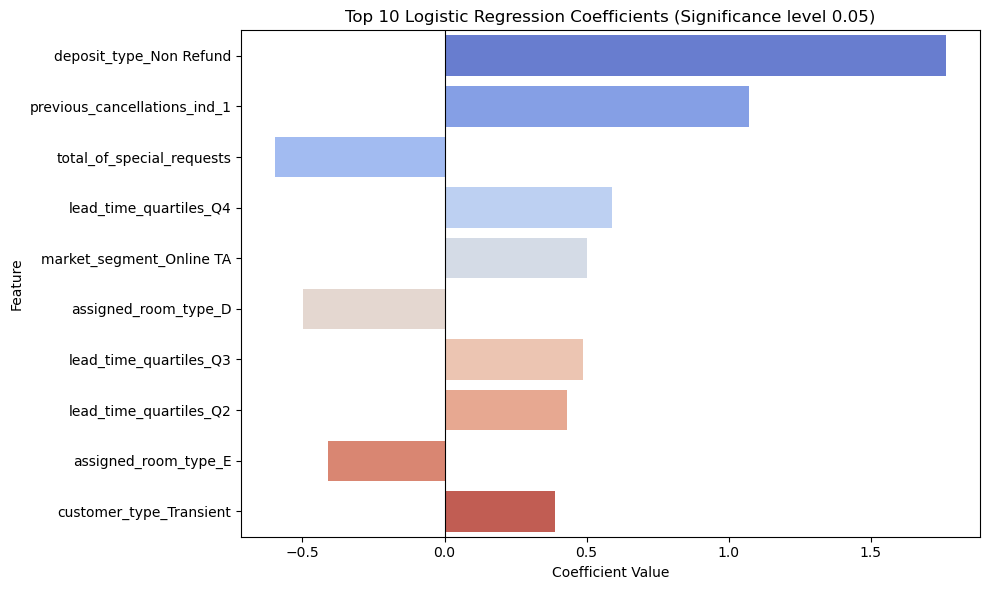

In [65]:
lr_significance_plot(lr_results)

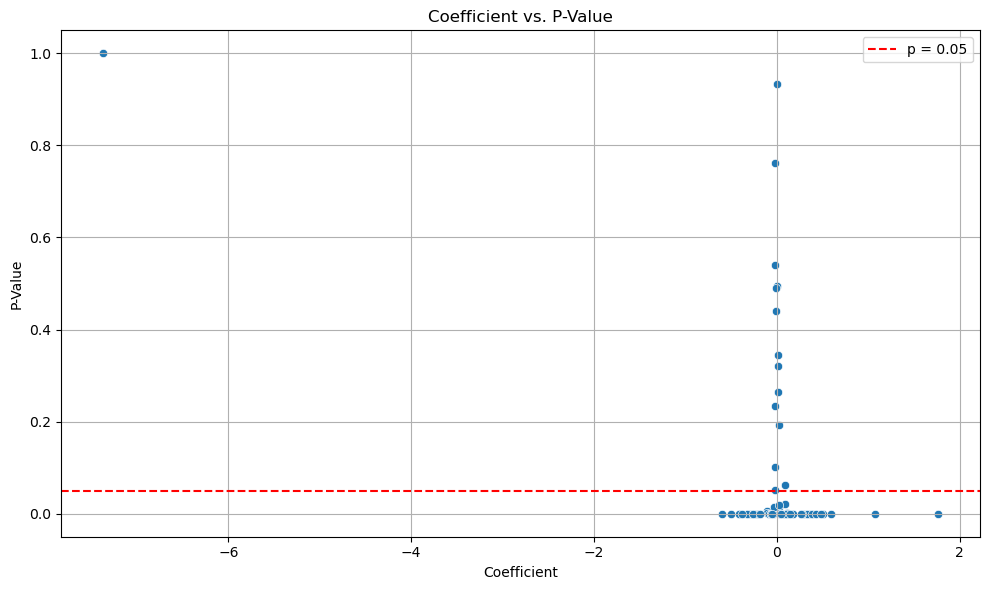

In [66]:
coeffs_pvalues_plot(lr_results)

In [67]:
xg(data)

Accuracy on Test Data:
0.8467318059299191
